The optimal seems to be to go to the instantaneous basis and rotating frame (?) in the complex formalism and integrate with "BDF"

In [1]:
import torch as t
import matplotlib.pyplot as plt
import os

import sys
dir_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(dir_path,'scripts'))

import importlib
import Systems as Systems
import Plotting as Plotting
import Controls as Controls
import Evolvers as Evolvers

from tqdm import tqdm
from time import time

from scipy.integrate import solve_ivp

In [2]:
importlib.reload(Systems)
importlib.reload(Plotting)
importlib.reload(Controls)
importlib.reload(Evolvers)

<module 'Evolvers' from 'c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\scripts\\Evolvers.py'>

In [10]:
params_dict = {
"T": 		30,
"NTrot": 	1000,
"q_max": 	8,
"lr": 		3e-4,
"Scheduler":	True,
"loss_funcs":	["C1_gate"],
"subNHilbert":  30,
"dim":          "2d",

"_SystemComments":"The following are the specifications for the 1DFlensmon, with respectively: 0.997*pi, 2*pi*10GHz and EJ/100",

"phi_ext": 3.132167875629024,
"EJ": 		62.83185307179586,
"EC": 		0.6283185307179586,

"decline_end":	10.0,
"ascend_start":	20.0,
"level":	1.0,
"envelope_amp":	0.2397,
"detuning":	0.2956,
"phase":	1.7529
}

In [11]:
class model(t.nn.Module,Systems.Periodic_System, Evolvers.QTrotter):
    def __init__(self,params_dict):
        super().__init__()
        self.beta = 1.0
        self.params_dict = params_dict

        self.ReLU = t.nn.ReLU()
        # self.heights = t.nn.parameter.Parameter(self.init_heights())
        self.prior_sigma = t.log(t.ones(998)/500)
        # self.log_sigma = t.nn.parameter.Parameter(self.prior_sigma.clone())

        super(t.nn.Module,self).__init__()
        # self.prepare_target_gate_adj()
    
    def init_heights(self):
        time = t.linspace(0,30,1000)[1:-1]
        alphas = t.sin(time)*t.exp(-(time-15)**2/10) + t.exp(-time/3) + t.exp(-(30 - time)/3)
        alphas = alphas - alphas.min()
        alphas = alphas/alphas.max()/2
        alphas = alphas + 0.5
        return self.restrict_output(self.restrict_diff(alphas)[1:-1],0.5,1)
        # return time*(time-30)/500 + 1

    def restrict_output(self,inp,Min,Max):
        return self.ReLU(inp - Min) - self.ReLU(inp - Max) + Min
    
    def forward(self, times, y):
        ind = (self.times - times).abs().argmin().item()
        alphas = self.restrict_output(self.heights,0.5,1.0)
        alphas = self.restrict_diff(alphas)[[ind]]
        H = self.get_H(alphas=alphas).squeeze()
        U = y#.view(30,30)
        # self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
        # U = t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))
        return (-1j*H@U).flatten()
    
    def V_2d(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            - alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)
    
    def get_jac(self, times, y):
        ind = (self.times - times).abs().argmin().item()
        alphas = self.restrict_output(self.heights,0.5,1.0)
        alphas = self.restrict_diff(alphas)[[ind]]
        H = self.get_H(alphas=alphas).squeeze()
        out = -1j*H
        # return t.block_diag(*(out for _ in range(30)))
        return out
    
    def prepare_target_gate_adj(self):
        tmp = t.eye(self.subNHilbert,dtype=t.cfloat)
        tmp[0,0] = 0
        tmp[0,1] = 1
        tmp[1,0] = 1
        tmp[1,1] = 0
        self.target_gate_adj = tmp.adjoint()
        self.basis_change = self.basis.adjoint()@self.eigvecs[:,:self.subNHilbert]
    
    def C1_gate(self,U):
        transformed = self.basis_change.adjoint()@U@self.basis_change
        dim = 2
        return 1 - 1/dim**2*t.square(t.abs(t.trace(self.target_gate_adj[:dim]@transformed[:,:dim])))
    
    def restrict_diff(self,heights):
        max_diff = 0.01
        out = t.zeros(heights.shape[0])
        out[0] = heights[0]
        for i in range(heights.shape[0]-1):
            diff = heights[i+1] - out[i]
            out[i+1] = out[i] + self.restrict_output(diff,0,max_diff) + self.restrict_output(diff,-max_diff,0)
        one = t.tensor([1.])
        return t.concat([one,self.restrict_output(out,0.5,1),one])

obj = model(params_dict)

I added a factor half to the cosines


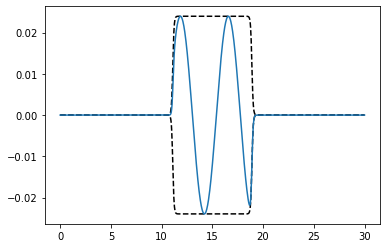

In [16]:
envelope_amp =	0.02397
detuning =	0.2956
phase =	1.7529

decline_end=	10.0+0.1
ascend_start=	20.0-0.1

def get_control(times):
    # times = t.as_tensor(times)
    # eigvals = t.linalg.eigvalsh(self.get_H(level.view(1)).squeeze())
    # omega_d = (eigvals[1] - eigvals[0])
    omega_d = 4.5
    pulse = t.cos(detuning*omega_d*(times - decline_end - phase))
    envelope = envelope_func(times)
    return envelope*pulse

def envelope_func(times):
    return envelope_amp*custom_Sigmoid(times-decline_end)*custom_Sigmoid(ascend_start - times)

def custom_Sigmoid(x):
    return t.sigmoid(20*t.pi/4*(x-1))

plt.plot(obj.times,get_control(obj.times),zorder=10)
plt.plot(obj.times,envelope_func(obj.times),'k--')
plt.plot(obj.times,-envelope_func(obj.times),'k--')

In [18]:
obj.NHilbert**2

289

In [137]:
# y0 = t.zeros(obj.NHilbert**2).cdouble()
# y0[0] = 1
H = obj.get_H(t.tensor([0.8])).cdouble().squeeze()
eigvals, eigvecs = t.linalg.eigh(H)
y0 = eigvecs[:,0]
eigvals = eigvals.cdouble()

f = t.diag_embed(eigvals).cdouble()
q_mat = (obj.EJ*eigvecs.adjoint()@obj.q_mat.cdouble()@eigvecs).cdouble()

G2 = eigvecs@t.diag_embed(eigvals)@eigvecs.adjoint()

# @t.jit.ScriptFunction
def _H(times):
    times = t.as_tensor(times).view(-1)
    # G = eigvecs@t.diag_embed(t.exp(1j*eigvals*(times-10)))@eigvecs.adjoint()
    H = obj.get_H(t.tensor([0.8]),get_control(times)).cdouble().squeeze()
    # H = G@H@G.adjoint() - G2

    # H = t.diag_embed(t.exp(1j*eigvals*times))@q_mat@t.diag_embed(t.exp(-1j*eigvals*times))*get_control(times)
    # H = q_mat*get_control(times) + f
    return H

def func(times,y):
    H = _H(times)
    return -1j*H@y

def jac(times,y):
    H = _H(times)
    return -1j*H

In [140]:
out3

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 54784
     njev: 1
      nlu: 4570
      sol: None
   status: 0
  success: True
        t: array([10.      , 10.10101 , 10.202021, 10.30303 , 10.40404 , 10.505051,
       10.606061, 10.70707 , 10.808081, 10.909091, 11.010101, 11.111111,
       11.212121, 11.313131, 11.414142, 11.515151, 11.616161, 11.717172,
       11.818182, 11.919191, 12.020202, 12.121212, 12.222222, 12.323232,
       12.424242, 12.525252, 12.626263, 12.727272, 12.828282, 12.929293,
       13.030303, 13.131312, 13.232323, 13.333333, 13.434343, 13.535353,
       13.636363, 13.737373, 13.838384, 13.939393, 14.040403, 14.141414,
       14.242424, 14.343433, 14.444444, 14.545454, 14.646464, 14.747474,
       14.848485, 14.949495, 15.050506, 15.151515, 15.252525, 15.353536,
       15.454546, 15.555555, 15.656566, 15.757576, 15.858586, 15.959596,
       16.060606, 16.161615, 16.262627, 16.363636, 16.464647, 16.565657,
       16.666

In [123]:
out3 = solve_ivp(func,y0=y0,rtol=1e-10,atol=1e-12,t_span=[10,20],t_eval=t.linspace(10,20,100), vectorized=True,method='BDF',jac=jac)

In [108]:
out2= solve_ivp(func,y0=y0,rtol=1e-10,atol=1e-12,t_span=[10,20],t_eval=t.linspace(10,20,100), vectorized=True,method='BDF',jac=jac)

In [105]:
out = solve_ivp(func,y0=y0,rtol=1e-10,atol=1e-12,t_span=[10,20],t_eval=t.linspace(10,20,100), vectorized=True,method='BDF',jac=jac)

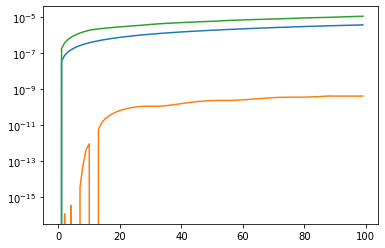

In [135]:
plt.plot((1- (eigvecs.adjoint().cdouble()@t.as_tensor(out3.y)).abs().square().cumsum(0))[-1])
plt.plot((1-t.as_tensor(out.y).abs().square().cumsum(0))[-1])
plt.plot((1-t.as_tensor(out2.y).abs().square().cumsum(0))[-1])

# i = 5
# plt.plot((eigvecs.adjoint().cdouble()@t.as_tensor(out3.y)).abs().square()[i])
# plt.plot(t.as_tensor(out.y).abs().square()[i])
# plt.plot(t.as_tensor(out2.y).abs().square()[i])
plt.yscale('log')

In [60]:
H = obj.get_H(t.tensor([0.8])).cdouble().squeeze()
eigvals, eigvecs = t.linalg.eigh(H)
y0 = eigvecs[:,0]
out = solve_ivp(func,y0=y0,rtol=1e-10,atol=1e-12,t_span=[10,20],t_eval=t.linspace(10,20,100), vectorized=True,method='BDF',jac=jac)

In [81]:
def G_adj(times):
    times = times.view(-1,1)# - 10
    return eigvecs@t.diag_embed(t.exp(-1j*eigvals*times))@eigvecs.adjoint()
G_tmp = G_adj(t.as_tensor(out.t))
tmp = [G_tmp[i]@t.as_tensor(out.y[:,[i]]) for i in range(100)]
tmp = t.concat(tmp,dim=1)
tmp.shape

torch.Size([289, 100])

In [83]:
H = obj.get_H(t.tensor([0.8])).cdouble().squeeze()
eigvals, eigvecs = t.linalg.eigh(H)
occs = 1- (eigvecs.adjoint()@tmp).abs().square().cumsum(0)

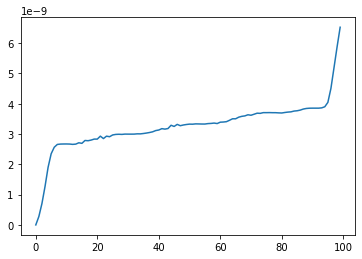

In [103]:
plt.plot(occs[-1:].T)

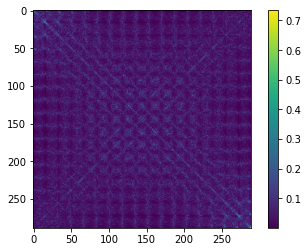

In [37]:
def G(times):
    times = times - 10
    return eigvecs@t.diag_embed(t.exp(1j*eigvals*times))@eigvecs.adjoint()
plt.imshow(G(20).abs())
plt.colorbar()

tensor([-6.1877e+00, -6.1762e+00, -6.1762e+00, -6.1625e+00, -6.1625e+00,
        -6.1459e+00, -6.1459e+00, -6.1257e+00, -6.1257e+00, -6.1006e+00,
        -6.1006e+00, -6.0691e+00, -6.0691e+00, -6.0287e+00, -6.0287e+00,
        -5.9757e+00, -5.9757e+00, -5.9043e+00, -5.9043e+00, -5.9043e+00,
        -5.8589e+00, -5.8589e+00, -5.8049e+00, -5.8049e+00, -5.8049e+00,
        -5.8049e+00, -5.7400e+00, -5.7400e+00, -5.6610e+00, -5.6610e+00,
        -5.6610e+00, -5.6610e+00, -5.5635e+00, -5.5635e+00, -5.4414e+00,
        -5.4414e+00, -5.4414e+00, -5.4414e+00, -5.4414e+00, -5.3421e+00,
        -5.3421e+00, -5.2858e+00, -5.2858e+00, -5.2243e+00, -5.2243e+00,
        -5.0832e+00, -5.0832e+00, -5.0832e+00, -5.0832e+00, -5.0832e+00,
        -5.0832e+00, -4.9124e+00, -4.9124e+00, -4.8132e+00, -4.8132e+00,
        -4.8132e+00, -4.7030e+00, -4.7030e+00, -4.6433e+00, -4.6433e+00,
        -4.4429e+00, -4.4429e+00, -4.4429e+00, -4.4429e+00, -4.4429e+00,
        -4.4429e+00, -4.4429e+00, -4.4429e+00, -4.2

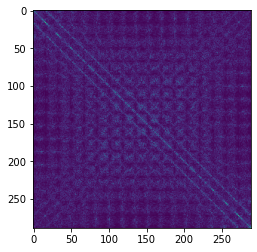

In [51]:
times = t.as_tensor(20).view(-1)
tmp = G(times)@obj.get_H(t.tensor([0.8]),get_control(times)).cdouble().squeeze()@G(times).adjoint()
plt.imshow((tmp-eigvecs@t.diag_embed(eigvals)@eigvecs.adjoint()).abs())
t.linalg.eigvalsh(tmp-eigvecs@t.diag_embed(eigvals)@eigvecs.adjoint())
# plt.imshow(().abs())

In [211]:
H = obj.KinE + obj.EJ*(-obj.cos_mat - 0.8*obj.cos2_mat)
K = H.real
S = H.imag
q_mat = obj.q_mat.real

eigvals, eigvecs = t.linalg.eigh(H.cdouble())
y0 = eigvecs[:,0]
u = y0.real
v = -y0.imag
EJ = obj.EJ
y0 = t.concat([u,v],dim=0)

In [189]:
def _realH(times):
    times = t.as_tensor(times).view(-1)
    V = obj.EJ*get_control(times)*q_mat
    upper = t.concat([S,-(K + V)],dim=1)
    lower = t.concat([K + V, S],dim=1)
    H = t.concat([upper,lower],dim=0)   
    return H

def func(times,y):
    H = _realH(times)
    return H@y

def jac(times,y):
    H = _realH(times)
    return H

In [237]:
rout = solve_ivp(func,y0=y0,rtol=1e-9,atol=1e-11,t_span=[10,20],t_eval=t.linspace(10,20,100), vectorized=True,method='LSODA',jac=jac)

In [238]:
u = rout.y[:289]
v = rout.y[289:]
psi = u -1j*v

In [239]:
occs = (eigvecs.adjoint()@t.as_tensor(psi,dtype=t.complex128)).abs().square()

In [241]:
1 - occs.sum(0)
# occs[0]

tensor([ 5.2114e-13,  2.4742e-08,  2.8283e-08,  4.8803e-08,  9.0506e-08,
         1.3372e-07,  1.5101e-07,  1.6052e-07,  1.6869e-07,  1.7477e-07,
         1.7652e-07,  3.6758e-08, -7.7036e-08, -1.8666e-07, -1.8720e-07,
        -1.8792e-07, -1.8864e-07, -1.8944e-07, -1.8945e-07, -1.8570e-07,
        -1.7882e-07, -1.7643e-07, -1.7635e-07, -1.7702e-07, -1.7760e-07,
        -1.7812e-07, -1.7859e-07, -1.7895e-07, -1.7931e-07, -1.7969e-07,
        -1.7997e-07, -1.8029e-07, -1.9642e-07, -1.9662e-07, -1.9698e-07,
        -1.9732e-07, -1.9762e-07, -1.9797e-07, -1.9833e-07, -1.9868e-07,
        -1.9892e-07, -1.9584e-07, -1.9306e-07, -1.9185e-07, -2.0382e-07,
        -2.0427e-07, -2.0470e-07, -2.0504e-07, -2.0527e-07, -2.2023e-07,
        -2.2047e-07, -2.2071e-07, -2.2098e-07, -2.2939e-07, -3.9162e-07,
        -3.9192e-07, -4.4352e-07, -4.4392e-07, -4.4427e-07, -4.4475e-07,
        -4.7031e-07, -5.3278e-07, -5.3411e-07, -5.3548e-07, -5.3680e-07,
        -5.2712e-07, -5.2120e-07, -5.1684e-07, -5.1

In [242]:
rout

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 98579
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([10.      , 10.10101 , 10.202021, 10.30303 , 10.40404 , 10.505051,
       10.606061, 10.70707 , 10.808081, 10.909091, 11.010101, 11.111111,
       11.212121, 11.313131, 11.414142, 11.515151, 11.616161, 11.717172,
       11.818182, 11.919191, 12.020202, 12.121212, 12.222222, 12.323232,
       12.424242, 12.525252, 12.626263, 12.727272, 12.828282, 12.929293,
       13.030303, 13.131312, 13.232323, 13.333333, 13.434343, 13.535353,
       13.636363, 13.737373, 13.838384, 13.939393, 14.040403, 14.141414,
       14.242424, 14.343433, 14.444444, 14.545454, 14.646464, 14.747474,
       14.848485, 14.949495, 15.050506, 15.151515, 15.252525, 15.353536,
       15.454546, 15.555555, 15.656566, 15.757576, 15.858586, 15.959596,
       16.060606, 16.161615, 16.262627, 16.363636, 16.464647, 16.565657,
       16.666668

(-0.01, 1.01)

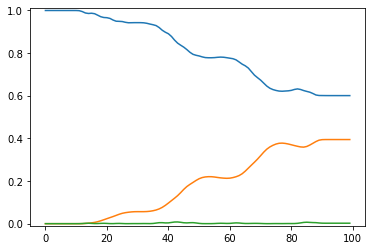

In [236]:
plt.plot(occs[:3].T)
plt.ylim(-0.01,1.01)
# plt.yscale('log')

In [227]:
rout

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 6512
     njev: 296
      nlu: 296
      sol: None
   status: 0
  success: True
        t: array([10.      , 10.10101 , 10.202021, 10.30303 , 10.40404 , 10.505051,
       10.606061, 10.70707 , 10.808081, 10.909091, 11.010101, 11.111111,
       11.212121, 11.313131, 11.414142, 11.515151, 11.616161, 11.717172,
       11.818182, 11.919191, 12.020202, 12.121212, 12.222222, 12.323232,
       12.424242, 12.525252, 12.626263, 12.727272, 12.828282, 12.929293,
       13.030303, 13.131312, 13.232323, 13.333333, 13.434343, 13.535353,
       13.636363, 13.737373, 13.838384, 13.939393, 14.040403, 14.141414,
       14.242424, 14.343433, 14.444444, 14.545454, 14.646464, 14.747474,
       14.848485, 14.949495, 15.050506, 15.151515, 15.252525, 15.353536,
       15.454546, 15.555555, 15.656566, 15.757576, 15.858586, 15.959596,
       16.060606, 16.161615, 16.262627, 16.363636, 16.464647, 16.565657,
       16.666

In [186]:
rout = solve_ivp(func,y0=y0,rtol=1e-10,atol=1e-12,t_span=[10,20],t_eval=t.linspace(10,20,100), vectorized=True,method='LSODA',jac=jac)

KeyboardInterrupt: 

In [187]:
rout

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 7
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([10.      , 10.10101 , 10.202021, 10.30303 , 10.40404 , 10.505051,
       10.606061, 10.70707 , 10.808081, 10.909091, 11.010101, 11.111111,
       11.212121, 11.313131, 11.414142, 11.515151, 11.616161, 11.717172,
       11.818182, 11.919191, 12.020202, 12.121212, 12.222222, 12.323232,
       12.424242, 12.525252, 12.626263, 12.727272, 12.828282, 12.929293,
       13.030303, 13.131312, 13.232323, 13.333333, 13.434343, 13.535353,
       13.636363, 13.737373, 13.838384, 13.939393, 14.040403, 14.141414,
       14.242424, 14.343433, 14.444444, 14.545454, 14.646464, 14.747474,
       14.848485, 14.949495, 15.050506, 15.151515, 15.252525, 15.353536,
       15.454546, 15.555555, 15.656566, 15.757576, 15.858586, 15.959596,
       16.060606, 16.161615, 16.262627, 16.363636, 16.464647, 16.565657,
       16.666668, 16

In [ ]:
x = [3,4,5,6]
y = [55,151,291,1255]
plt.plot(x,y)